# Workbook To Aggregate and Evalulate Results

The following workbook was used to aggregate results and create performance plots.

In [1]:
import pandas as pd
import seaborn as sns
import glob
from matplotlib import pyplot
import matplotlib.pyplot as plt

### Define functions to prepare data from multiple files of results

In [2]:
def prepare_data(file_name_list, column_to_compare, index_key, string_subset = None):
    # Function opens all files in file_name_list  that match description 
    # Pulls target column from all files into single dataframe and returns dataframe
    
    # Create list of file names
    file_list = glob.glob(file_name_list)
    
    # Create subset of files based on string_subset
    if string_subset != None:
        subset = []
        for each in string_subset:
            for i in file_list:
                if each in i:
                    subset.append(i)
        file_list = subset

    df_new = pd.DataFrame()
    
    #read first file to pull in target column
    df = pd.read_csv(file_list[0]) 
    
    #index key is the column we want to pull and compare between files
    df_new[index_key] = df[index_key]

    for idx, each in enumerate(file_list):
        for sub in string_subset:
            if sub in each:
                df_1 = pd.read_csv(each) 
                df_new[sub+str(idx)] = df_1[column_to_compare]
    
    df_new = df_new.dropna(axis=1)
    return df_new

def add_means_by_strata(df, groups):
    #function adds a mean for the specified groups
    #groups specifies string to find in column name to group by
    #e.g. b0_base vs b0_stochastic
    for each in groups:
        subset = df[[x for x in df.columns if each in x ]]
        df[each+'_mean'] = subset.mean(axis=1)

def get_mean_multiple_cols(file_name_list, columns_to_include, string_subset, index_key):
    new_df = pd.DataFrame()
    i= 0
    for col in columns_to_include:
        
        results = prepare_data(file_name_list=file_name_list,
                       column_to_compare=col,index_key='Epoch',
                      string_subset = string_subset)
        
        add_means_by_strata(results, string_subset)
        
        if i == 0:
            new_df['Epoch'] = results['Epoch']
        
        new_df[col+'_'+string_subset[0]+'_mean'] = results[string_subset[0]+'_mean']
        new_df[col+'_'+string_subset[1]+'_mean'] = results[string_subset[1]+'_mean']
        i+=1
        
    return new_df[1:]


def get_multiple_cols(file_name_list, columns_to_include, string_subset, index_key):
    new_df = pd.DataFrame()
    i = 0
    for col in columns_to_include:
        results = prepare_data(file_name_list=file_name_list,
                               column_to_compare=col, index_key='Epoch',
                               string_subset=string_subset)

        results = results.drop(columns=['Epoch'])

        results.columns = [col_name + '_' + col for col_name in results.columns]

        new_df = pd.concat([new_df, results], axis=1)
        i += 1
    return new_df[1:]


def rename(x):
    if 'stochastic' in x[1]:
        if 'Val' in x[1]:
            return 'stochastic_val'
        if 'Train' in x[1]:
            return 'stochastic_train'
    
    if 'split' in x[1]:
        if 'Val' in x[1]:
            return 'stochastic_val'
        if 'Train' in x[1]:
            return 'stochastic_train'
    
    if 'Project' in x[1]:
        if 'Val' in x[1]:
            return 'Project_val'
        if 'Train' in x[1]:
            return 'Project_train'
        
    if 'Official' in x[1]:
        if 'Val' in x[1]:
            return 'Official_val'
        if 'Train' in x[1]:
            return 'Official_train'    
    
    if 'project' in x[1]:
        if 'Val' in x[1]:
            return 'Project_val'
        if 'Train' in x[1]:
            return 'Project_train'
    
    if 'official' in x[1]:
        if 'Val' in x[1]:
            return 'Official_val'
        if 'Train' in x[1]:
            return 'Official_train'
        
    
    if 'base' in x[1]:
        if 'Val' in x[1]:
            return 'base_val'
        if 'Train' in x[1]:
            return 'base_train'
            
    if 'fs_tta' in x[1]:
        if 'Val' in x[1]:
            return 'fs_tta_val'
        if 'Train' in x[1]:
            return 'fs_tta_train'
         
    
    if 'b4' in x[1]:
        if 'Val' in x[1]:
            return 'b4_val'
        if 'Train' in x[1]:
            return 'b4_train'
    else:
        if 'Val' in x[1]:
            return 'base_val'
        if 'Train' in x[1]:
            return 'base_train'
        
    
def get_max_value_per_column(string_subset, dataframe):
    for group in string_subset:
        max_value = 0
        for col in dataframe.columns:
            if group in col:
                max_value = max(dataframe[[col]].max()[0], max_value)
        print(group + ' max:')
        print(max_value)

## Graph Functions 

Text(0, 0.5, 'ROC AUC')

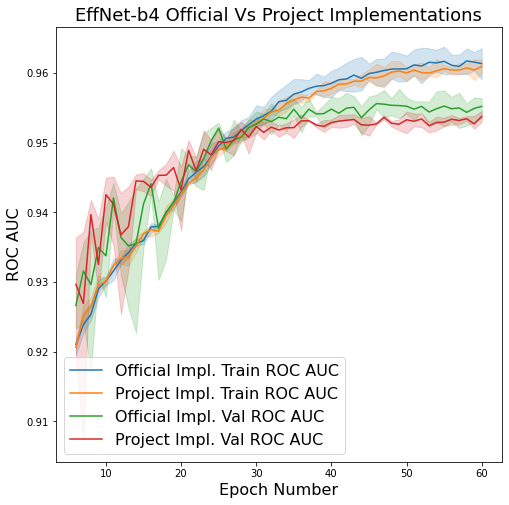

In [3]:
params = {'legend.fontsize': 16,
          'legend.handlelength': 2}
plt.rcParams.update(params)


new = get_multiple_cols(file_name_list="1024x1024ResultsFinal/b4/b4compare/*_per_epoch.csv",
                        columns_to_include=['Train RoC','Val RoC'],
                        string_subset=['official', 'project'], index_key='Epoch')



new = new[5:]
new['Epoch'] = new.index
new = new.melt(id_vars='Epoch')

new['new'] = new.apply(lambda x: rename(x),axis=1)
rfig, ax = pyplot.subplots(figsize=(8,8))

sns.lineplot(ax=ax,data=new,x='Epoch',y='value', hue='new')

legend = ax.legend().get_texts()
legend[0].set_text('Official Impl. Train ROC AUC')
legend[1].set_text('Project Impl. Train ROC AUC')
legend[2].set_text('Official Impl. Val ROC AUC')
legend[3].set_text('Project Impl. Val ROC AUC')


plt.title('EffNet-b4 Official Vs Project Implementations', fontsize=18)
plt.xlabel('Epoch Number', fontsize=16)
plt.ylabel('ROC AUC', fontsize=16)
plt.savefig('Figures/b4OfficialvsProjectSpread.jpg',bbox_inches='tight',dpi=1200)

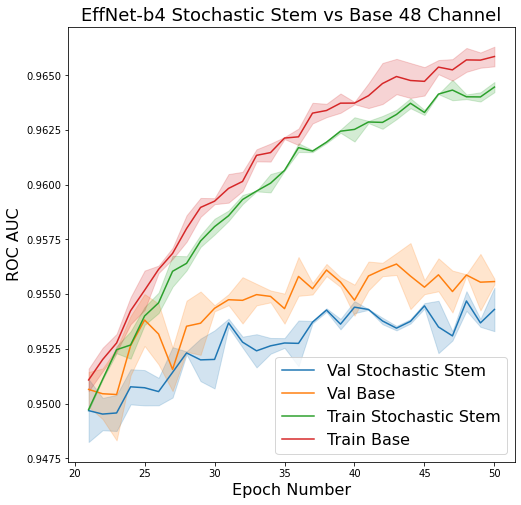

In [53]:
params = {'legend.fontsize': 16,
          'legend.handlelength': 2}
plt.rcParams.update(params)


new = get_multiple_cols(file_name_list="1024x1024ResultsFinal/b4/b4_compare/*_per_epoch.csv",
                        columns_to_include=['Val RoC', 'Train RoC'],
                        string_subset=['stochastic','base'], index_key='Epoch')

new = new[20:]
new['Epoch'] = new.index
new = new.melt(id_vars='Epoch')

new['new'] = new.apply(lambda x: rename(x),axis=1)
rfig, ax = pyplot.subplots(figsize=(8,8))

sns.lineplot(ax=ax,data=new,x='Epoch',y='value', hue='new')

legend = ax.legend().get_texts()
legend[0].set_text('Val Stochastic Stem')
legend[1].set_text('Val Base')
legend[2].set_text('Train Stochastic Stem')
legend[3].set_text('Train Base')



plt.title('EffNet-b4 Stochastic Stem vs Base 48 Channel', fontsize=18)
plt.xlabel('Epoch Number', fontsize=16)
plt.ylabel('ROC AUC', fontsize=16)
plt.savefig('b4StochsaticStemVs48BaseSpread.jpg',bbox_inches='tight',dpi=1200)

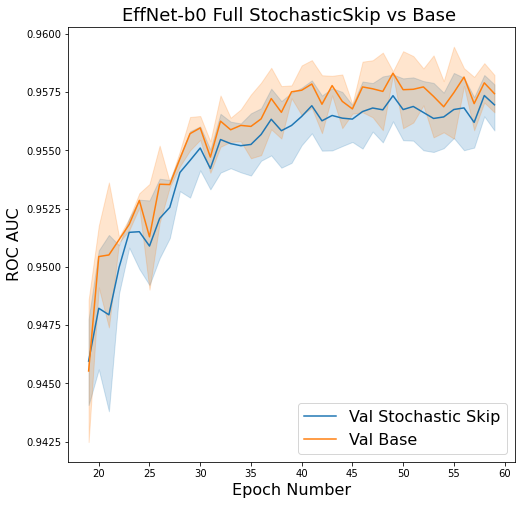

In [28]:
params = {'legend.fontsize': 16,
          'legend.handlelength': 2,
         'legend.loc':'lower right'}
plt.rcParams.update(params)

new = prepare_data(file_name_list="1024x1024ResultsFinal/b0/stochasticskip/*_per_epoch.csv",
                             column_to_compare='Val RoC', 
                             string_subset=['stochasticskip','Base_32'], index_key='Epoch')
new = new[20:]
new = new.melt(id_vars='Epoch')
new['new'] = new.apply(lambda x: rename(x),axis=1)
rfig, ax = pyplot.subplots(figsize=(8,8))

sns.lineplot(ax=ax,data=new,x='Epoch',y='value', hue='new')


legend = ax.legend().get_texts()
legend[0].set_text('Val Stochastic Skip')
legend[1].set_text('Val Base')

plt.title('EffNet-b0 Full StochasticSkip vs Base ', fontsize=18)
plt.xlabel('Epoch Number', fontsize=16)
plt.ylabel('ROC AUC', fontsize=16)
plt.savefig('1024FullStochasticSkipSpread.jpg',bbox_inches='tight',dpi=1200)

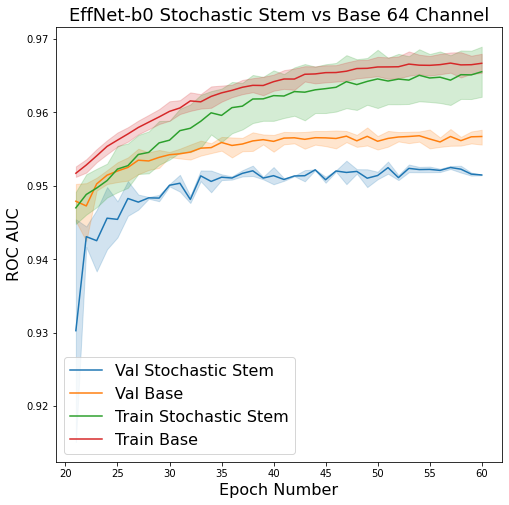

In [28]:
params = {'legend.fontsize': 16,
          'legend.handlelength': 2}
plt.rcParams.update(params)


new = get_multiple_cols(file_name_list="1024x1024ResultsFinal/b0/*_per_epoch.csv",
                        columns_to_include=['Val RoC', 'Train RoC'],
                        string_subset=['stochastic','base_64'], index_key='Epoch')


new = new[20:]
new['Epoch'] = new.index
new = new.melt(id_vars='Epoch')

new['new'] = new.apply(lambda x: rename(x),axis=1)
rfig, ax = pyplot.subplots(figsize=(8,8))

sns.lineplot(ax=ax,data=new,x='Epoch',y='value', hue='new')

legend = ax.legend().get_texts()
legend[0].set_text('Val Stochastic Stem')
legend[1].set_text('Val Base')
legend[2].set_text('Train Stochastic Stem')
legend[3].set_text('Train Base')



plt.title('EffNet-b0 Stochastic Stem vs Base 64 Channel', fontsize=18)
plt.xlabel('Epoch Number', fontsize=16)
plt.ylabel('ROC AUC', fontsize=16)
plt.savefig('StochsaticStemVs64BaseSpread.jpg',bbox_inches='tight',dpi=1200)

Text(0, 0.5, 'ROC AUC')

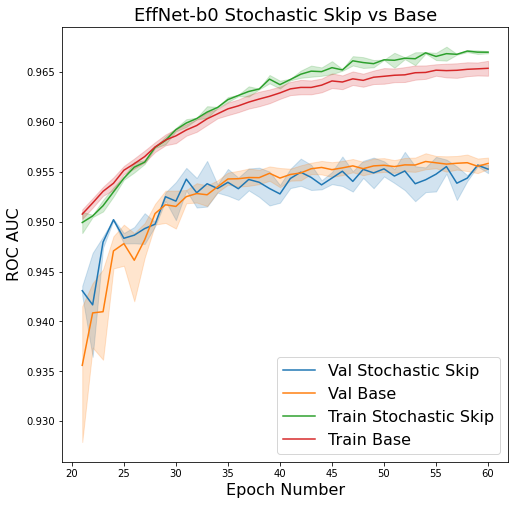

In [25]:
params = {'legend.fontsize': 16,
          'legend.handlelength': 2}
plt.rcParams.update(params)


new = get_multiple_cols(file_name_list="1024x1024ResultsFinal/b0/stoch_skip/*_per_epoch.csv",
                        columns_to_include=['Val RoC', 'Train RoC'],
                        string_subset=['stochastic','base'], index_key='Epoch')


new = new[20:]
new['Epoch'] = new.index
new = new.melt(id_vars='Epoch')

new['new'] = new.apply(lambda x: rename(x),axis=1)
rfig, ax = pyplot.subplots(figsize=(8,8))

sns.lineplot(ax=ax,data=new,x='Epoch',y='value', hue='new')

legend = ax.legend().get_texts()
legend[0].set_text('Val Stochastic Skip')
legend[1].set_text('Val Base')
legend[2].set_text('Train Stochastic Skip')
legend[3].set_text('Train Base')



plt.title('EffNet-b0 Stochastic Skip vs Base', fontsize=18)
plt.xlabel('Epoch Number', fontsize=16)
plt.ylabel('ROC AUC', fontsize=16)
#plt.savefig('b0StochsaticSkipVsBaseSpreadFull.jpg',bbox_inches='tight',dpi=1200)

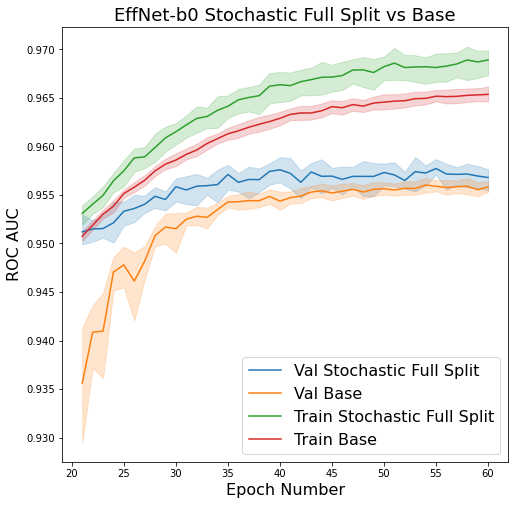

In [131]:
params = {'legend.fontsize': 16,
          'legend.handlelength': 2}
plt.rcParams.update(params)


new = get_multiple_cols(file_name_list="1024x1024ResultsFinal/b0/full_split/*_per_epoch.csv",
                        columns_to_include=['Val RoC', 'Train RoC'],
                        string_subset=['fullsplit','base'], index_key='Epoch')

new = new[20:]
new['Epoch'] = new.index
new = new.melt(id_vars='Epoch')

new['new'] = new.apply(lambda x: rename(x),axis=1)
rfig, ax = pyplot.subplots(figsize=(8,8))

sns.lineplot(ax=ax,data=new,x='Epoch',y='value', hue='new')

legend = ax.legend().get_texts()
legend[0].set_text('Val Stochastic Full Split')
legend[1].set_text('Val Base')
legend[2].set_text('Train Stochastic Full Split')
legend[3].set_text('Train Base')



plt.title('EffNet-b0 Stochastic Full Split vs Base', fontsize=18)
plt.xlabel('Epoch Number', fontsize=16)
plt.ylabel('ROC AUC', fontsize=16)
plt.savefig('b0FullSplitVsBaseSpreadFull.jpg',bbox_inches='tight',dpi=1200)

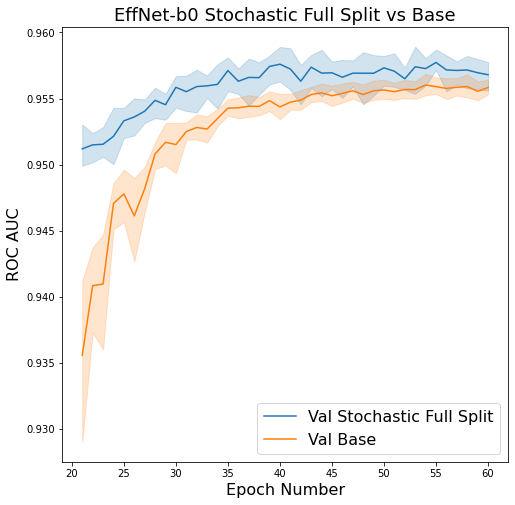

In [132]:
params = {'legend.fontsize': 16,
          'legend.handlelength': 2}
plt.rcParams.update(params)


new = get_multiple_cols(file_name_list="1024x1024ResultsFinal/b0/full_split/*_per_epoch.csv",
                        columns_to_include=['Val RoC'],
                        string_subset=['fullsplit','base'], index_key='Epoch')

new = new[20:]
new['Epoch'] = new.index
new = new.melt(id_vars='Epoch')

new['new'] = new.apply(lambda x: rename(x),axis=1)
rfig, ax = pyplot.subplots(figsize=(8,8))

sns.lineplot(ax=ax,data=new,x='Epoch',y='value', hue='new')

legend = ax.legend().get_texts()
legend[0].set_text('Val Stochastic Full Split')
legend[1].set_text('Val Base')



plt.title('EffNet-b0 Stochastic Full Split vs Base', fontsize=18)
plt.xlabel('Epoch Number', fontsize=16)
plt.ylabel('ROC AUC', fontsize=16)
plt.savefig('b0FullSplitVsBaseSpreadValidation.jpg',bbox_inches='tight',dpi=1200)

Text(0, 0.5, 'ROC AUC')

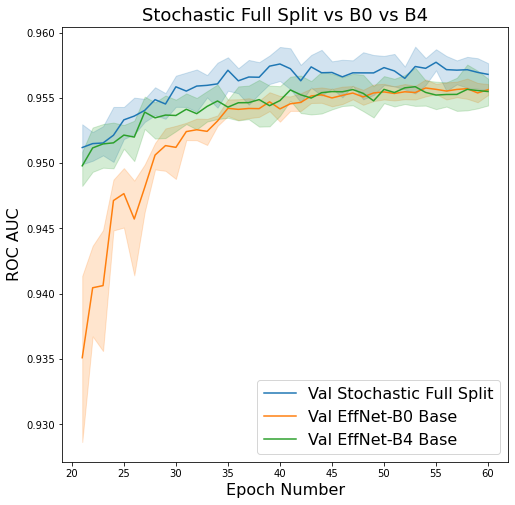

In [158]:
params = {'legend.fontsize': 16,
          'legend.handlelength': 2}
plt.rcParams.update(params)


new = get_multiple_cols(file_name_list="1024x1024ResultsFinal/b0/allcompare/*_per_epoch.csv",
                        columns_to_include=['Val RoC'],
                        string_subset=['fullsplit','base', 'b4'], index_key='Epoch')

new = new[20:]
new['Epoch'] = new.index
new = new.melt(id_vars='Epoch')

new['new'] = new.apply(lambda x: rename(x),axis=1)
rfig, ax = pyplot.subplots(figsize=(8,8))

sns.lineplot(ax=ax,data=new,x='Epoch',y='value', hue='new')

legend = ax.legend().get_texts()
legend[0].set_text('Val Stochastic Full Split')
legend[1].set_text('Val EffNet-B0 Base')
legend[2].set_text('Val EffNet-B4 Base')

plt.title('Stochastic Full Split vs B0 vs B4', fontsize=18)
plt.xlabel('Epoch Number', fontsize=16)
plt.ylabel('ROC AUC', fontsize=16)
#plt.savefig('AllCompare.jpg',bbox_inches='tight',dpi=1200)

fs_tta max:
0.9604583862445126
b4 max:
0.95781156045763
fullsplit max:
0.9594000698009716
full_split max:
0


Text(0, 0.5, 'ROC AUC')

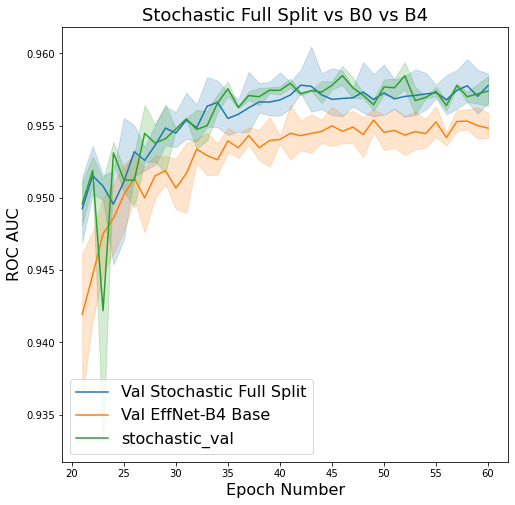

In [10]:
params = {'legend.fontsize': 16,
          'legend.handlelength': 2}
plt.rcParams.update(params)


new = get_multiple_cols(file_name_list="fresh_rerun/*_per_epoch.csv",
                        columns_to_include=['Val RoC'],
                        string_subset=['fs_tta','b4','fullsplit','full_split'], index_key='Epoch')

new = new[20:]
get_max_value_per_column(string_subset=['fs_tta','b4','fullsplit','full_split'], dataframe=new)
new['Epoch'] = new.index
new = new.melt(id_vars='Epoch')



new['new'] = new.apply(lambda x: rename(x),axis=1)
rfig, ax = pyplot.subplots(figsize=(8,8))

sns.lineplot(ax=ax,data=new,x='Epoch',y='value', hue='new')

legend = ax.legend().get_texts()
legend[0].set_text('Val Stochastic Full Split')
legend[1].set_text('Val EffNet-B4 Base')
#legend[2].set_text('Val EffNet-B4 Base')

plt.title('Stochastic Full Split vs B0 vs B4', fontsize=18)
plt.xlabel('Epoch Number', fontsize=16)
plt.ylabel('ROC AUC', fontsize=16)

#get_max_value_per_column(string_subset, dataframe):